In [1]:
import numpy as np
import pandas as pd
import dicom
import matplotlib.pyplot as plt
import scipy.ndimage
from skimage import measure, morphology
from sklearn.cluster import KMeans
from skimage.transform import resize
# import importlib
# importlib.import_module('mpl_toolkits.mplot3d').__path__
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import os

%matplotlib inline

In [2]:
path = r"F:\Data Science\DS Bowl\stage1_sample"
patients = os.listdir(path)
patients.sort()
print(patients[0])

00cba091fa4ad62cc3200a657aeb957e


In [3]:
labels_path = r"F:\Data Science\DS Bowl\stage1_labels.csv"
labels_df = pd.read_csv(labels_path, index_col=0)
labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [40]:
lstFilesDCM = []  # create an empty list
for patient in patients:
#     label = labels_df.get_value(patient, 'cancer')
    for dirName, subdirList, fileList in os.walk(path + '/' + patient):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))

In [4]:
# def read_ct_scan(folder_name):
#         # Read the slices from the dicom file
#         slices = [dicom.read_file(filename) for filename in folder_name]
        
#         # Sort the dicom slices in their respective order
#         slices.sort(key=lambda x: int(x.InstanceNumber))
        
#         # Get the pixel values for all the slices
#         slices = np.stack([s.pixel_array for s in slices])
#         slices[slices == -2000] = 0
#         return slices
# metadata = read_ct_scan(lstFilesDCM)

In [4]:
def load_images(file_path):
    slices = [dicom.read_file(s) for s in file_path]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
# metadata = load_images(lstFilesDCM)

In [11]:
# Storing the sample metadata to a text file for easy interpretation and understanding
with open("Sample_metadata.txt", 'w') as file_handler:
    for item in metadata:
        file_handler.write("{}\n".format(item))

To convert pixel values to HU I have used the following formula
   
       hu = pixel_value * slope + intercept

In [5]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)    
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# imgs = get_pixels_hu(metadata)

134

In [13]:
output_path = "./Output"
if not os.path.exists(output_path):
    os.makedirs(output_path)
np.save(output_path + "fullimages.npy", imgs)

### Some information about HU values - from Wikipedia
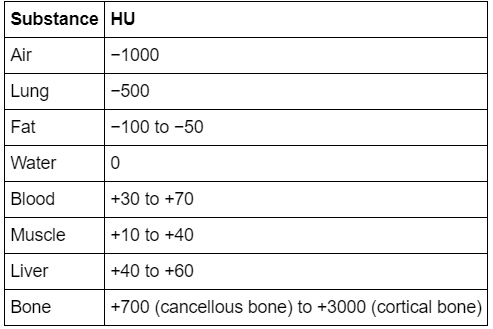



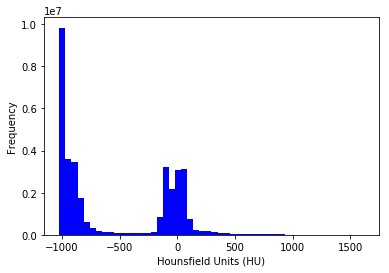

In [14]:
plt.hist(imgs.flatten(), bins=50, color='b')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

- From the above plot we can see that there is a lot of air.
- There is some lung
- There are lots of soft tissues. liver etc.
- There are few bones.

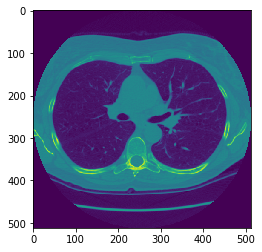

In [15]:
plt.imshow(imgs[50])
plt.show()

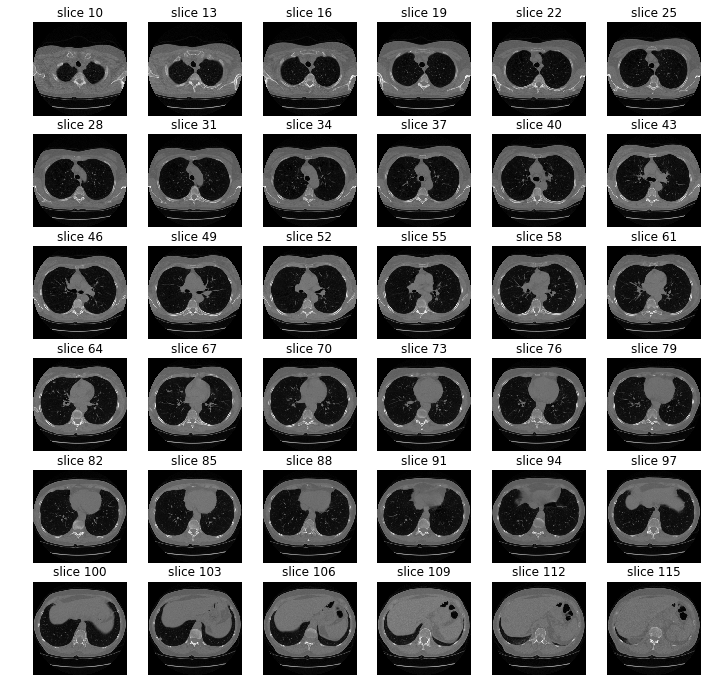

In [16]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()
imgs_to_process = np.load(output_path + 'fullimages.npy')
sample_stack(imgs_to_process)

In [6]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
#     print(image.shape)
#     print(resize_factor)
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing
# pix_resampled, spacing = resample(imgs, metadata, [1, 1, 1])

In [18]:
print("Shape before resampling: ", imgs.shape)
print("Shape after resampling:", pix_resampled.shape)
print(spacing)

Shape before resampling:  (134, 512, 512)
Shape after resampling: (335, 306, 306)
[ 1.         0.9999996  0.9999996]


In [19]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 

    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    plt.show()

Transposing surface
Calculating surface
Drawing


C:\Users\dhava\AppData\Local\Continuum\Anaconda2\envs\neuralnets\lib\site-packages\ipykernel\__main__.py:44: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


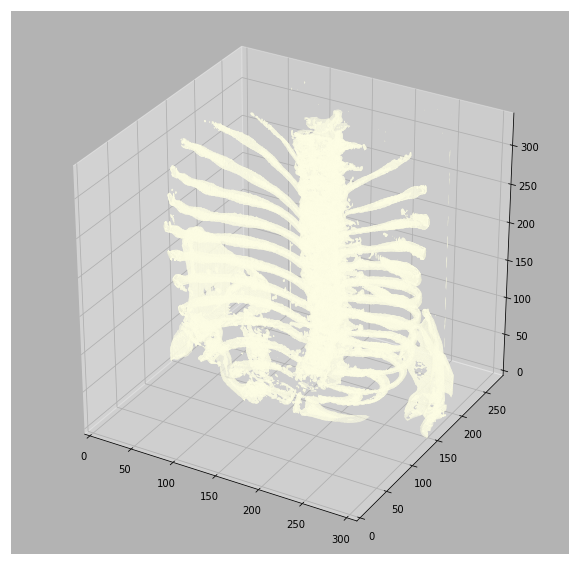

In [20]:
v, f = make_mesh(pix_resampled, 350)
plt_3d(v, f)

In [49]:
pix_resampled.shape

(335, 306, 306)

In [7]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    '''
    We have to make sure that we set our threshold between the lung pixel values and the denser tissue pixel values.
    To do this, we reset the pixels with the minimum value to the average pixel value near the center of the picture
    and perform kmeans clustering with k=2. 
    This seems to work well for both scenarios.
    '''
    row_size= img.shape[0]
    col_size = img.shape[1]
    mean = np.mean(img)
    std = np.std(img)
    img = img - mean
    img = img / std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size / 5) : int(col_size / 5 * 4), int(row_size / 5) : int(row_size / 5 * 4)] 
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
#     print(labels[0])
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

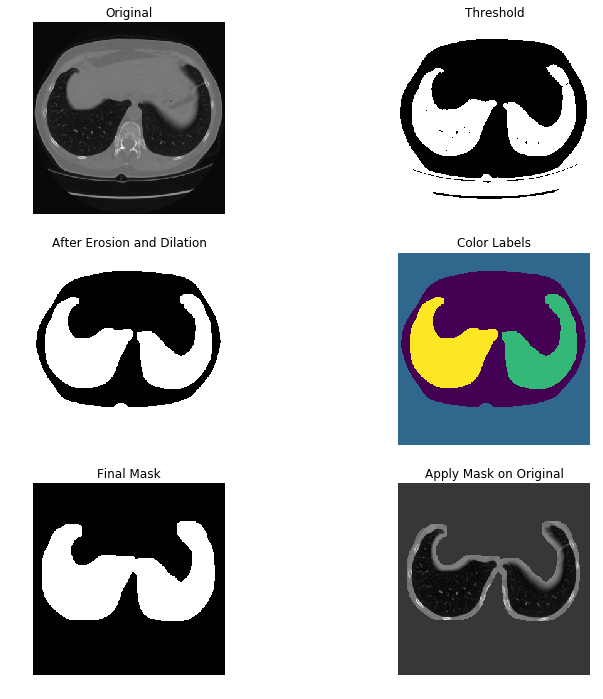

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ..., 
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [52]:
im = pix_resampled[250]
make_lungmask(im, display = True)

(306, 306)

In [32]:
masked_lung = []
for img in pix_resampled:
    masked_lung.append(make_lungmask(img))

# sample_stack(masked_lung, show_every=10)

In [53]:
np.save(output_path + "maskedimages.npy", masked_lung)

In [54]:
masked_lung = np.array(masked_lung)
masked_lung.shape

(335, 306, 306)

In [48]:
import os, urllib.request
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)

In [8]:
import mxnet as mx
import glob
def get_extractor():
    print("Loading Resnet-50 Model ...")
    model = mx.model.FeedForward.load('model/resnet-50', 0, ctx=mx.cpu(), numpy_batch_size=1)
    fea_symbol = model.symbol.get_internals()["flatten0_output"]
    feature_extractor = mx.model.FeedForward(ctx=mx.cpu(), symbol=fea_symbol, numpy_batch_size=64,
                                             arg_params=model.arg_params, aux_params=model.aux_params,
                                             allow_extra_params=True)

    return feature_extractor


def read_data(path, labels_path, output_path):
    # path = r"F:\Data Science\DS Bowl\stage1_sample"
    print("Reading Data ...")
    patients = os.listdir(path)
    patients.sort()
    labels_df = pd.read_csv(labels_path, index_col=0)
    labels_df.head()
    net = get_extractor()
    count = 0
    much_data = []
    for folder in glob.glob(path + "/*"):
        lstFilesDCM = []  # create an empty list
        masked_lung = []
        patient_name = folder.split('\\')[-1]
        try:
            label = labels_df.get_value(patient_name, 'cancer')
            for s in os.listdir(folder):
                if ".dcm" in s.lower():
                    lstFilesDCM.append(os.path.join(folder,s))
            # print("Loading Images ...")
            scans = load_images(lstFilesDCM)
            # print("Done ...")
            images = get_pixels_hu(scans)
            # print(images.shape)
            pix_resampled, spacing = resample(images, scans, [1, 1, 1])
            # x, y, z = pix_resampled.shape
            # pix_resampled = pix_resampled.reshape((x, y, z, 1))
            # feats = net.predict(pix_resampled)
            # print(feats.shape)
            # np.save(output_path + "folder.npy", feats)
            for img in pix_resampled:
                # print("learning features ...")
                # feats = net.predict(images)
                # print(feats.shape)
                # np.save(output_path + "folder.npy", feats)
                masked_lung.append(make_lungmask(img))
            # feats = net.predict(pix_resampled)
            masked_lung = np.array(masked_lung)
            # print(masked_lung.shape)
            # exit()
            if label == 1: label = np.array([0,1])
            elif label == 0: label = np.array([1,0])
            much_data.append([masked_lung,label])
        except KeyError as e:
            print("This is unlabelled data!!")
    np.save('muchdata.npy', much_data)

In [9]:
path = r"F:\Data Science\DS Bowl\stage1_sample"
labels_path = r"F:\Data Science\DS Bowl\stage1_labels.csv"
output_path = "./Output"
read_data(path, labels_path, output_path)

Reading Data ...
Loading Resnet-50 Model ...


C:\Users\dhava\AppData\Local\Continuum\Anaconda2\envs\neuralnets\lib\site-packages\mxnet\model.py:901: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  **kwargs)
C:\Users\dhava\AppData\Local\Continuum\Anaconda2\envs\neuralnets\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
C:\Users\dhava\AppData\Local\Continuum\Anaconda2\envs\neuralnets\lib\site-packages\dicom\filereader.py:305: DeprecationWarning: generator 'data_element_generator' raised StopIteration
  raw_data_element = next(de_gen)


This is unlabelled data!!


MemoryError: 

C:\Users\dhava\AppData\Local\Continuum\Anaconda2\envs\neuralnets\lib\site-packages\matplotlib\animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


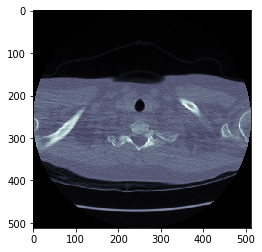

In [36]:
import matplotlib.animation as animation
def animate(pat, gifname):
    # Based on @Zombie's code
    fig = plt.figure()
    anim = plt.imshow(pat[0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(pat[i])
        return anim,
    a = animation.FuncAnimation(fig, update, frames=range(len(pat)), interval=50, blit=True)
    a.save(gifname, writer='imagemagick')
#     return a
animate(patients_pixels, 'test.html')


In [35]:
# print(len(pix_resampled))

335
